In [1]:
from itertools import chain, cycle
from IPython.display import display_html
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

# ignore warnings
import warnings
warnings.filterwarnings('ignore')


%matplotlib inline
plt.rcParams.update({'figure.figsize': (7, 5), 'figure.dpi': 100})
sns.set_style("whitegrid")
sns.set()

In [2]:
df = pd.read_csv("segmented_rfm_data.csv")
df

,Customer ID,Recency,Frequency,MonetaryValue,R,F,M,RFM_segment,RFM_score,Segment
0,12346,327,1,77183.60,1,1,4,114,6,Middle
1,12747,24,103,4196.01,3,4,4,344,11,Top
2,12748,5,4243,32449.90,4,4,4,444,12,Top
3,12749,24,199,4090.88,3,4,4,344,11,Top
4,12820,46,59,942.34,3,3,3,333,9,Low
...,...,...,...,...,...,...,...,...,...,...
3916,18280,161,10,180.60,2,1,1,211,4,Low
3917,18281,5,7,80.82,4,1,1,411,6,Middle
3918,18282,217,12,178.05,1,1,1,111,3,Low
3919,18283,11,688,1998.68,4,4,4,444,12,Top


## Remove category feature that we added when we performed manual segmentation

In [3]:
df.drop(["Segment"], axis=1)

,Customer ID,Recency,Frequency,MonetaryValue,R,F,M,RFM_segment,RFM_score
0,12346,327,1,77183.60,1,1,4,114,6
1,12747,24,103,4196.01,3,4,4,344,11
2,12748,5,4243,32449.90,4,4,4,444,12
3,12749,24,199,4090.88,3,4,4,344,11
4,12820,46,59,942.34,3,3,3,333,9
...,...,...,...,...,...,...,...,...,...
3916,18280,161,10,180.60,2,1,1,211,4
3917,18281,5,7,80.82,4,1,1,411,6
3918,18282,217,12,178.05,1,1,1,111,3
3919,18283,11,688,1998.68,4,4,4,444,12


# Lets preprocess the data in order to apply K-Means Clustering

    The varaiables should be distributed symmetrically
    Variables should have similar average values
    Variables should have similar standard deviation values



## Lets check distribution of R, F, M variables

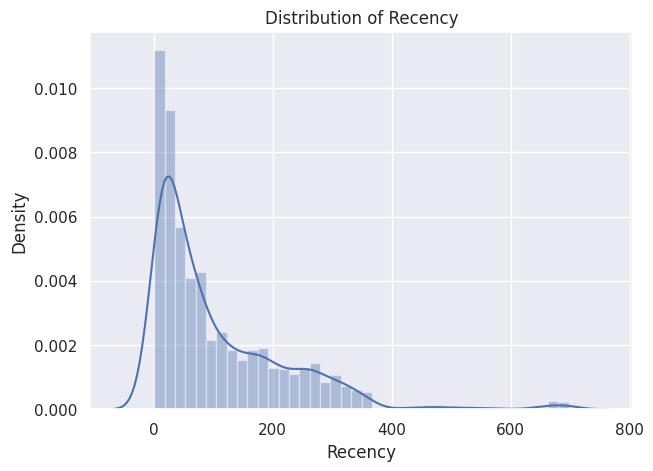

In [4]:
sns.distplot(df["Recency"])
plt.gca().set(title="Distribution of Recency")
plt.show()

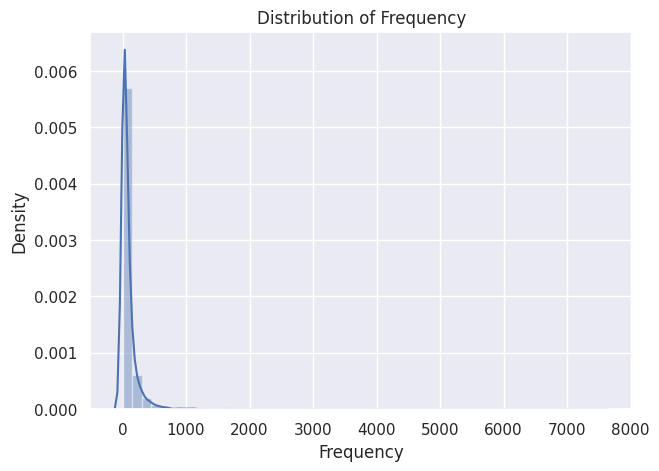

In [5]:
sns.distplot(df["Frequency"])
plt.gca().set(title="Distribution of Frequency")
plt.show()

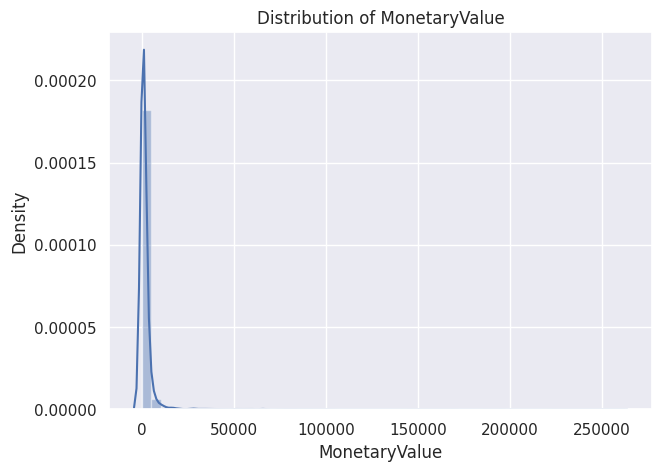

In [6]:
sns.distplot(df["MonetaryValue"])
plt.gca().set(title="Distribution of MonetaryValue")
plt.show()

## From above graph , we can see that above three distributions are skewed
## So we need to transform the data in order to make it nearly a normal distribution
### As these distributions are positively skewed i.e. right skewed , we can do some transformations like:
    Log transformation
    Square root
    Cube root transformation

In [7]:
df.describe()

,Customer ID,Recency,Frequency,MonetaryValue,R,F,M,RFM_segment,RFM_score
count,3921.000000,3921.000000,3921.000000,3921.000000,3921.000000,3921.000000,3921.000000,3921.000000,3921.000000
mean,15561.471563,106.554195,87.857689,1852.437695,2.516195,2.492731,2.499617,279.046417,7.508544
std,1576.823683,115.037406,210.631771,7473.955913,1.124089,1.115297,1.118291,118.076220,2.776907
min,12346.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,111.000000,3.000000
25%,14208.000000,23.000000,16.000000,294.060000,2.000000,1.000000,1.000000,211.000000,5.000000
50%,15569.000000,62.000000,40.000000,638.240000,3.000000,2.000000,2.000000,311.000000,7.000000
75%,16913.000000,163.000000,97.000000,1561.610000,4.000000,3.000000,3.000000,411.000000,10.000000
max,18287.000000,698.000000,7523.000000,259657.300000,4.000000,4.000000,4.000000,444.000000,12.000000


## Since from above graph, our data do not contains negative values. So we  apply log transformation to this data


## From above summary , we can see that MonetaryValue feature has minimum value of 0, which do not have any true meaning for transaction. SO its better to remove them from our data

## We also see that we do not get constant mean and standard deviation values.

In [8]:
df[df["MonetaryValue"] == 0]

,Customer ID,Recency,Frequency,MonetaryValue,R,F,M,RFM_segment,RFM_score,Segment
314,13256,16,1,0.0,4,1,1,411,6,Middle


In [9]:
# Lets remove this record
df = df[df['MonetaryValue'] > 0]
df.reset_index(drop=True, inplace=True)

In [10]:
df.describe()

,Customer ID,Recency,Frequency,MonetaryValue,R,F,M,RFM_segment,RFM_score
count,3920.000000,3920.000000,3920.000000,3920.000000,3920.000000,3920.000000,3920.000000,3920.000000,3920.000000
mean,15562.059694,106.577296,87.879847,1852.910256,2.515816,2.493112,2.500000,279.012755,7.508929
std,1576.594671,115.042986,210.654072,7474.850821,1.123983,1.115185,1.118177,118.072466,2.777157
min,12346.000000,1.000000,1.000000,3.750000,1.000000,1.000000,1.000000,111.000000,3.000000
25%,14208.750000,23.000000,16.000000,294.105000,2.000000,1.000000,1.750000,211.000000,5.000000
50%,15569.500000,62.000000,40.000000,638.460000,3.000000,2.000000,2.500000,311.000000,7.000000
75%,16913.250000,163.000000,97.000000,1561.937500,4.000000,3.000000,3.250000,411.000000,10.000000
max,18287.000000,698.000000,7523.000000,259657.300000,4.000000,4.000000,4.000000,444.000000,12.000000


### Lets take data of Recency,Frequency, MonetaryValue features only

In [11]:
data = df[['Recency', 'Frequency', 'MonetaryValue']]

In [12]:
data_log = np.log(data)

scaler = StandardScaler()
scaler.fit(data_log)

data_normalized = scaler.transform(data_log)

data_norm = pd.DataFrame(data=data_log, index=data.index, columns=data.columns)

In [13]:
data_norm.head()

,Recency,Frequency,MonetaryValue
0,5.789960,0.000000,11.253942
1,3.178054,4.634729,8.341889
2,1.609438,8.353026,10.387453
3,3.178054,5.293305,8.316515
4,3.828641,4.077537,6.848366


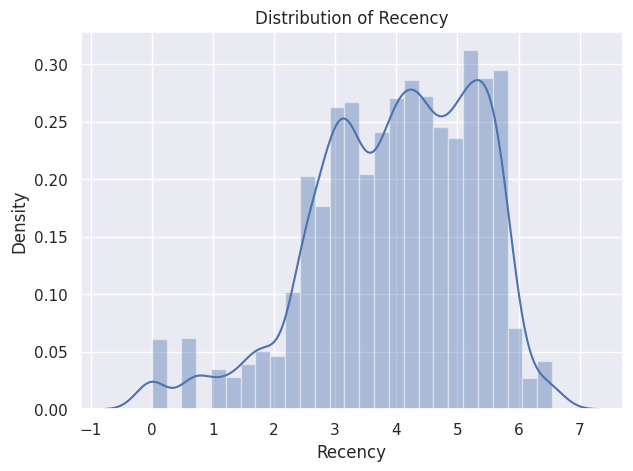

In [14]:
sns.distplot(data_norm["Recency"])
plt.gca().set(title="Distribution of Recency")
plt.show()

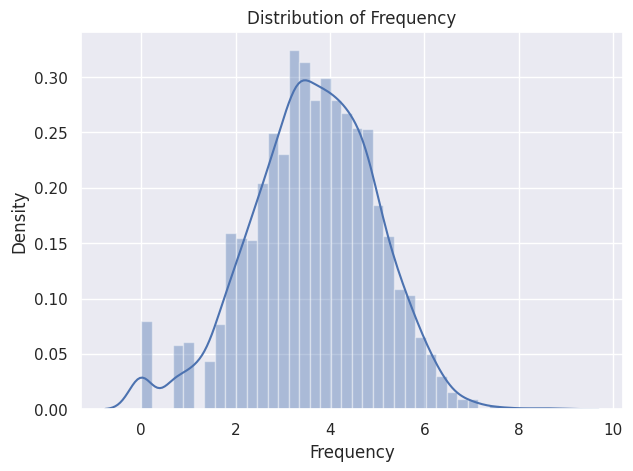

In [15]:
sns.distplot(data_norm["Frequency"])
plt.gca().set(title="Distribution of Frequency")
plt.show()

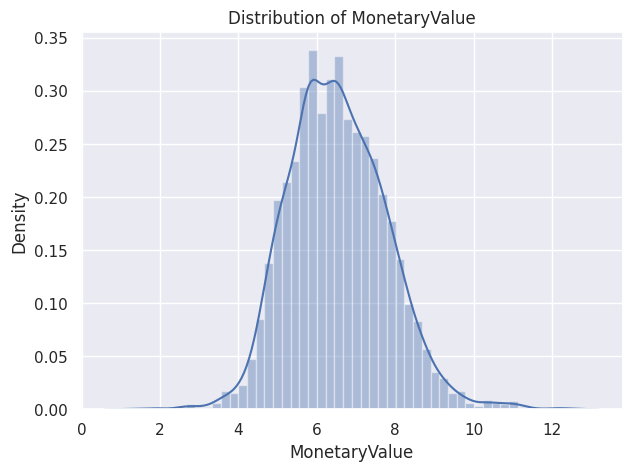

In [16]:
sns.distplot(data_norm["MonetaryValue"])
plt.gca().set(title="Distribution of MonetaryValue")
plt.show()

## Lets define a dictionary to save sum of squared errors so that we can easily get 'k' values and their respective values of errors for K-means cluster model
    In this method, the sum of distances of observations from their cluster centroids, called Within-Cluster-Sum-of-Squares (WCSS)

In [17]:
within_cluster_sum_of_squares = {}

In [18]:
k_limit = 21

# Lets build K-means model for values starting from 1 to 21
for k in range(1, 21):
    # define model with number of clusters
    kmeans = KMeans(n_clusters=k, init='k-means++',
                    max_iter=300,  n_init=10, random_state=1)

    # Fit KMeans on the normalized dataset
    kmeans.fit(data_norm)

    # Record sum of squared distances to k element of dictionary for K value of model
    within_cluster_sum_of_squares[k] = kmeans.inertia_

In [19]:
within_cluster_sum_of_squares

{1: 19890.156455047818,
 2: 10695.134068383531,
 3: 8461.10153931967,
 4: 6958.894889909167,
 5: 5967.01163175454,
 6: 5310.079561449406,
 7: 4766.081083270587,
 8: 4358.977000262002,
 9: 4096.096978331599,
 10: 3824.130103255553,
 11: 3588.273800402286,
 12: 3377.22202590699,
 13: 3202.362812228332,
 14: 3025.605891581218,
 15: 2886.951050617992,
 16: 2781.7301576176606,
 17: 2689.793529729685,
 18: 2605.6215380333288,
 19: 2525.3670210912474,
 20: 2453.7630824473536}

## Now lets find optimal value of K using Elbow method

### Elbow method

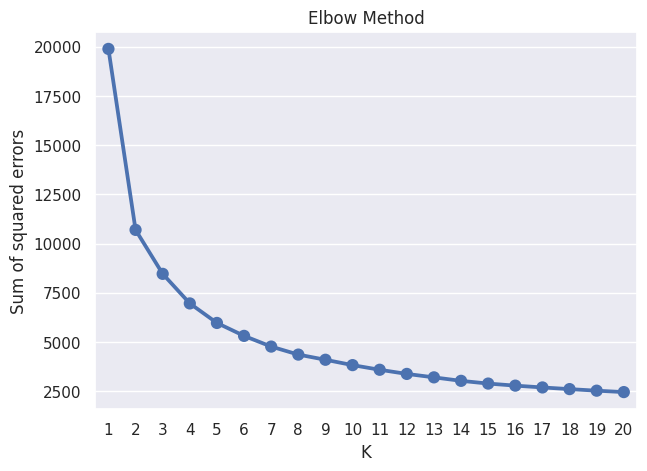

In [20]:
x = list(within_cluster_sum_of_squares.keys())
y = list(within_cluster_sum_of_squares.values())
sns.pointplot(x=x, y=y)
plt.gca().set(title="Elbow Method", xlabel="K", ylabel="Sum of squared errors")
plt.show()

## From above plot
    we can see that optimal no of clusters is either 3 or 4

## So 
    lets take k=3 and k=4 to find results and compare them

## First K=3

In [21]:
# Again build model and set number of clusters to 3
k = 3
kmeans_3 = KMeans(n_clusters=k, init='k-means++',
                  max_iter=300,  n_init=10, random_state=1)

# fit to normalized data
kmeans_3.fit(data_norm)

# Extracting cluster labels
cluster_labels = kmeans_3.labels_
cluster_labels

array([2, 0, 0, ..., 1, 0, 0], dtype=int32)

In [22]:
data_norm_k3 = data_norm.assign(Cluster=cluster_labels)
data_k3 = data.assign(Cluster=cluster_labels)

In [23]:
# Summary of each cluster obtained by K=3 in original data
summary_k3 = data_k3.groupby('Cluster').agg({'Recency': 'mean',
                                             'Frequency': 'mean',
                                             'MonetaryValue': ['mean', 'count']})
summary_k3

Recency   Frequency MonetaryValue      
               mean        mean          mean count
Cluster                                            
0         18.891209  241.375824   5588.628297   910
1        191.324891   14.792330    286.659407  1382
2         83.649263   64.124079   1094.344689  1628

## Now K=4

In [24]:
# Again build model and set number of clusters to 3
k = 4
kmeans_4 = KMeans(n_clusters=k, init='k-means++',
                  max_iter=300,  n_init=10, random_state=1)

# fit to normalized data
kmeans_4.fit(data_norm)

# Extracting cluster labels
cluster_labels = kmeans_4.labels_
cluster_labels

array([2, 1, 1, ..., 0, 1, 1], dtype=int32)

In [25]:
data_norm_k4 = data_norm.assign(Cluster=cluster_labels)
data_k4 = data.assign(Cluster=cluster_labels)

In [26]:
# Summary of each cluster obtained by K=r in original data
summary_k4 = data_k4.groupby('Cluster').agg({'Recency': 'mean',
                                             'Frequency': 'mean',
                                             'MonetaryValue': ['mean', 'count']})
summary_k4

Recency   Frequency MonetaryValue      
               mean        mean          mean count
Cluster                                            
0        193.568562   13.027592    269.119867  1196
1         22.082108  266.051471   6169.637500   816
2        134.570541   68.399290   1218.897962  1127
3         21.248399   44.460948    682.994417   781

## Now lets compare above two summaries

In [27]:
def display_side_by_side(*args, titles=cycle([''])):
    html_str = ''
    for df, title in zip(args, chain(titles, cycle(['</br>']))):
        html_str += '<th style="text-align:center"><td>'
        html_str += f'<h2 style="text-align:center !important">{title}</h2>'
        html_str += df.to_html().replace('table', 'table')
        html_str += '</td></th>'
    display_html(html_str, raw=True)

In [28]:
display_side_by_side(summary_k3, summary_k4, titles=['K=3', 'K=4'])

K=3 
 
 
 
 Recency 
 Frequency 
 MonetaryValue 
 
 
 
 mean 
 mean 
 mean 
 count 
 
 
 Cluster 
 
 
 
 
 
 
 
 
 0 
 18.891209 
 241.375824 
 5588.628297 
 910 
 
 
 1 
 191.324891 
 14.792330 
 286.659407 
 1382 
 
 
 2 
 83.649263 
 64.124079 
 1094.344689 
 1628 
 
 
 K=4 
 
 
 
 Recency 
 Frequency 
 MonetaryValue 
 
 
 
 mean 
 mean 
 mean 
 count 
 
 
 Cluster 
 
 
 
 
 
 
 
 
 0 
 193.568562 
 13.027592 
 269.119867 
 1196 
 
 
 1 
 22.082108 
 266.051471 
 6169.637500 
 816 
 
 
 2 
 134.570541 
 68.399290 
 1218.897962 
 1127 
 
 
 3 
 21.248399 
 44.460948 
 682.994417 
 781

## Clearly K=4 , i.e. 4 clusters give us more detailed information

     We are going to use the fit predict method that returns for each observation which cluster it belongs to. The cluster to which customers belongs and it will return this cluster numbers into a single vector that is  called y K-means

In [29]:
y_kmeans_4 = kmeans_4.fit_predict(data_norm)
y_kmeans_4

array([2, 1, 1, ..., 0, 1, 1], dtype=int32)

## Visualising the clusters

In [30]:
ori_data_array = np.array(data_norm)
ori_data_array

array([[ 5.78996017,  0.        , 11.25394228],
       [ 3.17805383,  4.63472899,  8.34188935],
       [ 1.60943791,  8.35302585, 10.38745264],
       ...,
       [ 5.37989735,  2.48490665,  5.18206441],
       [ 2.39789527,  6.53378884,  7.60024224],
       [ 0.        ,  4.24849524,  7.5160415 ]])

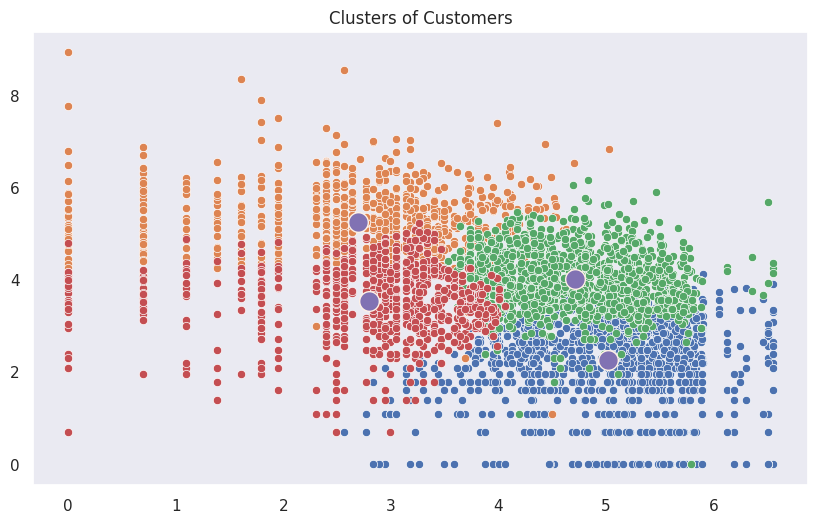

In [31]:
sns.set_style("dark")
plt.figure(figsize=(10, 6))
sns.scatterplot(x=ori_data_array[y_kmeans_4 == 0, 0],
                y=ori_data_array[y_kmeans_4 == 0, 1])
sns.scatterplot(x=ori_data_array[y_kmeans_4 == 1, 0],
                y=ori_data_array[y_kmeans_4 == 1, 1])
sns.scatterplot(x=ori_data_array[y_kmeans_4 == 2, 0],
                y=ori_data_array[y_kmeans_4 == 2, 1])
sns.scatterplot(x=ori_data_array[y_kmeans_4 == 3, 0],
                y=ori_data_array[y_kmeans_4 == 3, 1])

# Show the Centroids
# sns.scatterplot(x=kmeans_4.cluster_centers_[:, 0], y=kmeans_4.cluster_centers_[:, 1],size=2000)
plt.scatter(kmeans_4.cluster_centers_[:, 0], kmeans_4.cluster_centers_[
            :, 1], s=200,  edgecolors='#fff1e6', label='Centroids')
plt.title('Clusters of Customers')

plt.show()

For n_clusters = 2 The average silhouette_score is : 0.39241152972461785
For n_clusters = 3 The average silhouette_score is : 0.28856701429057086
For n_clusters = 4 The average silhouette_score is : 0.2983497256227329
For n_clusters = 5 The average silhouette_score is : 0.27507080226233654
For n_clusters = 6 The average silhouette_score is : 0.274525005636584
For n_clusters = 7 The average silhouette_score is : 0.27135138665103054
For n_clusters = 8 The average silhouette_score is : 0.2664123842525858
For n_clusters = 9 The average silhouette_score is : 0.2728360387849087
For n_clusters = 10 The average silhouette_score is : 0.2663820875409334


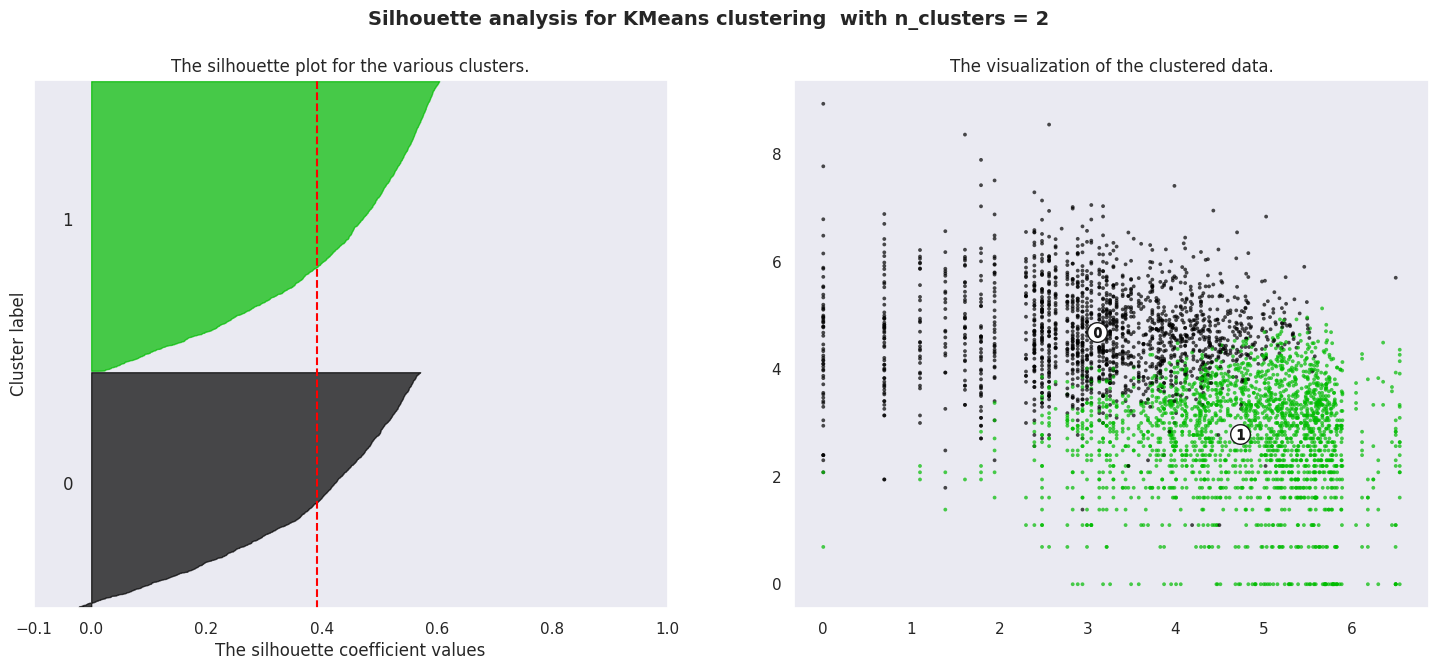

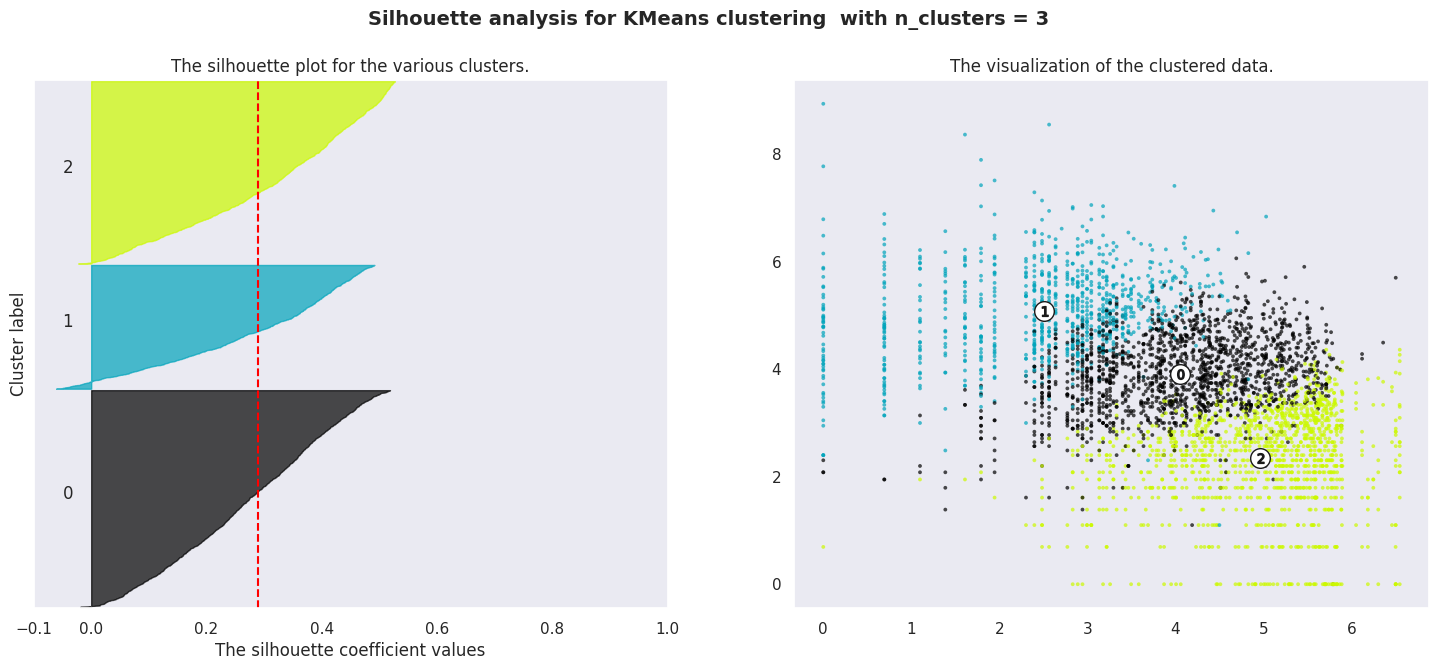

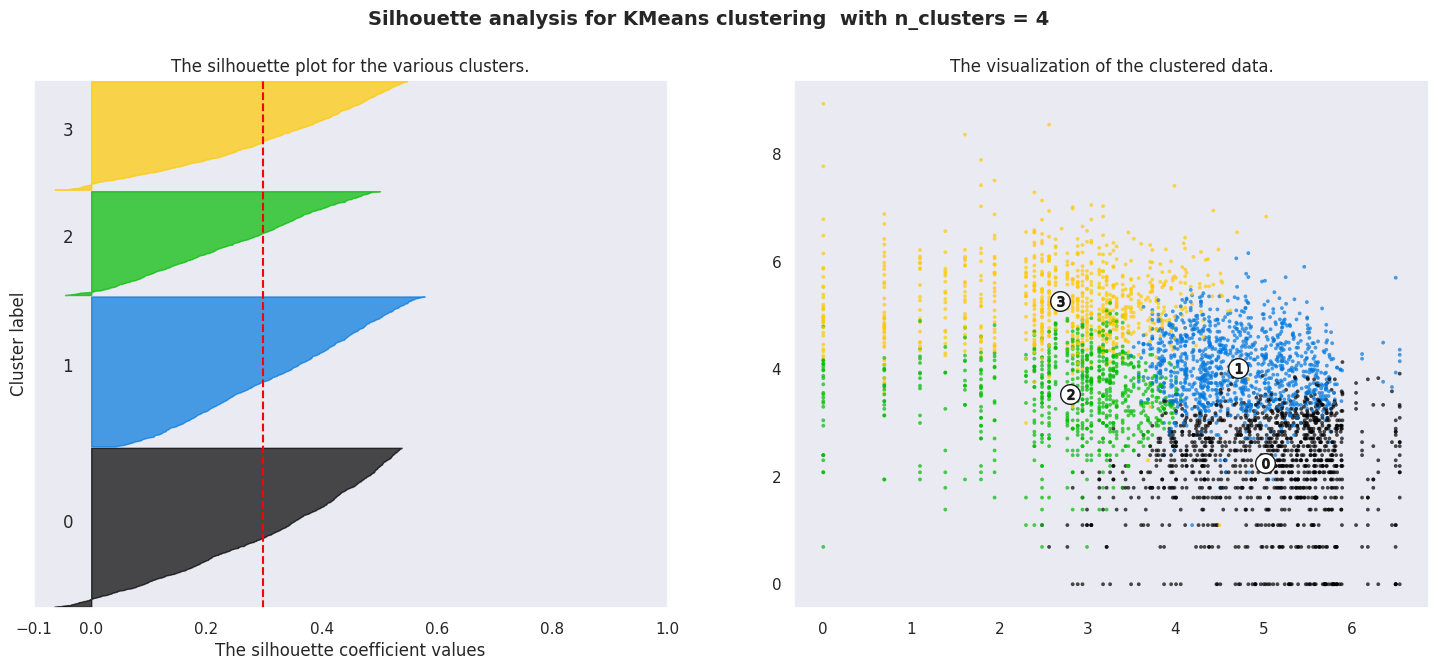

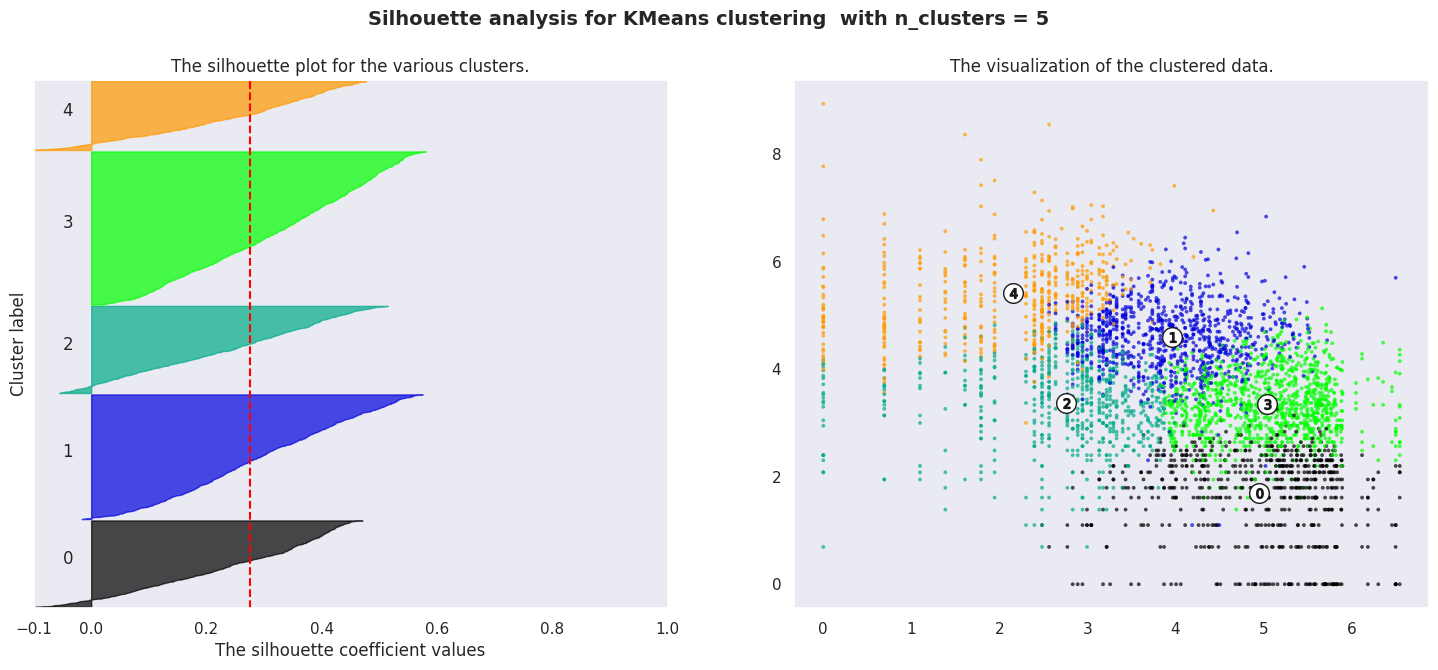

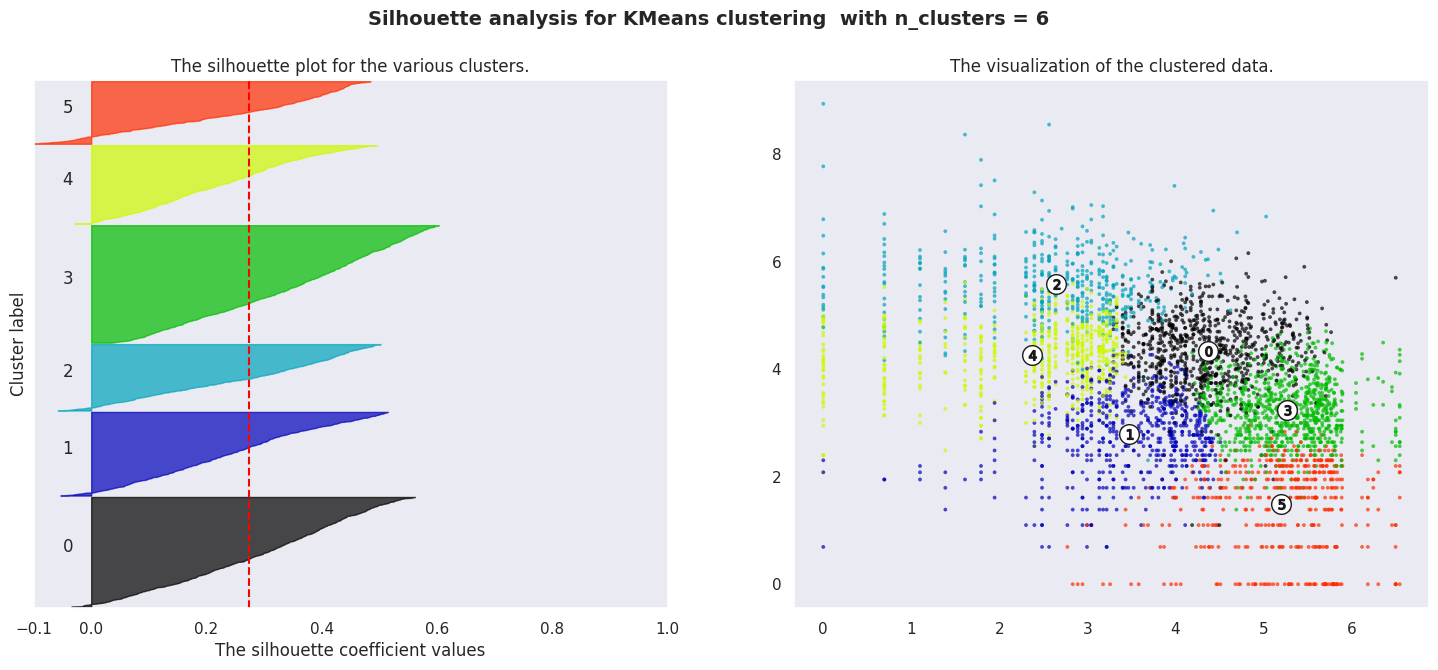

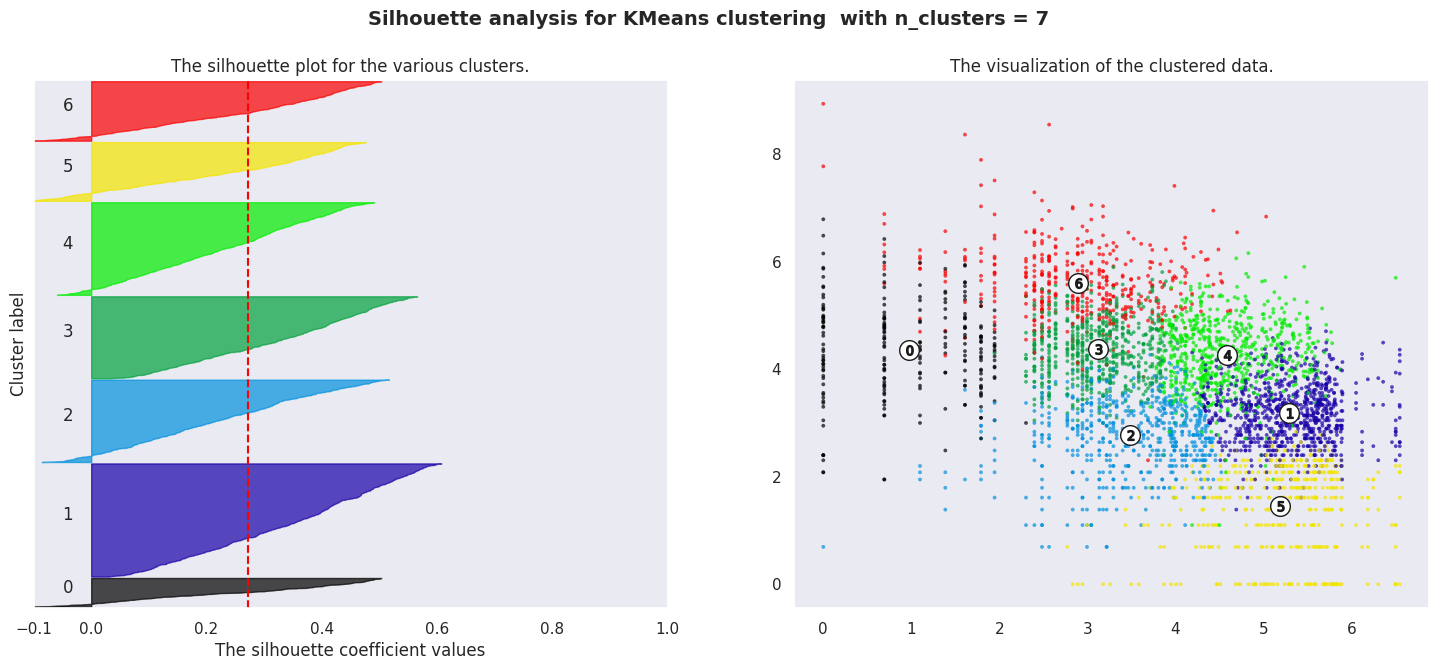

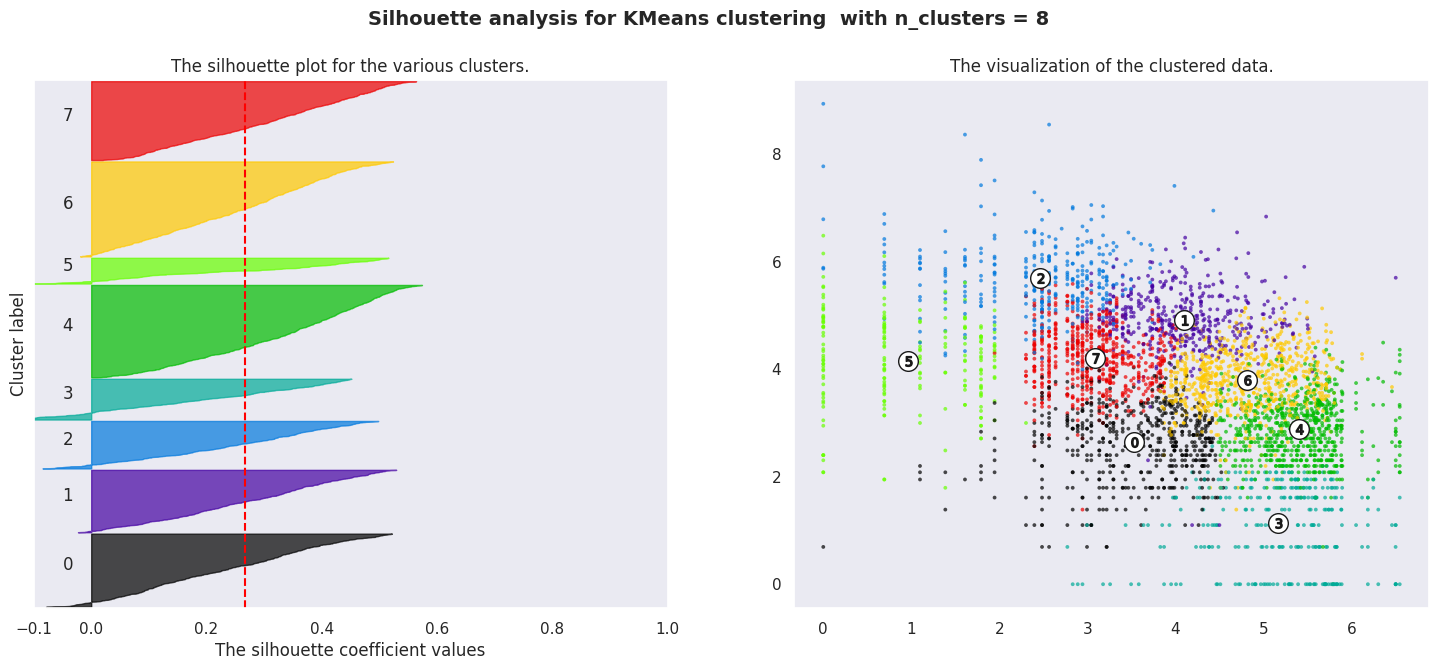

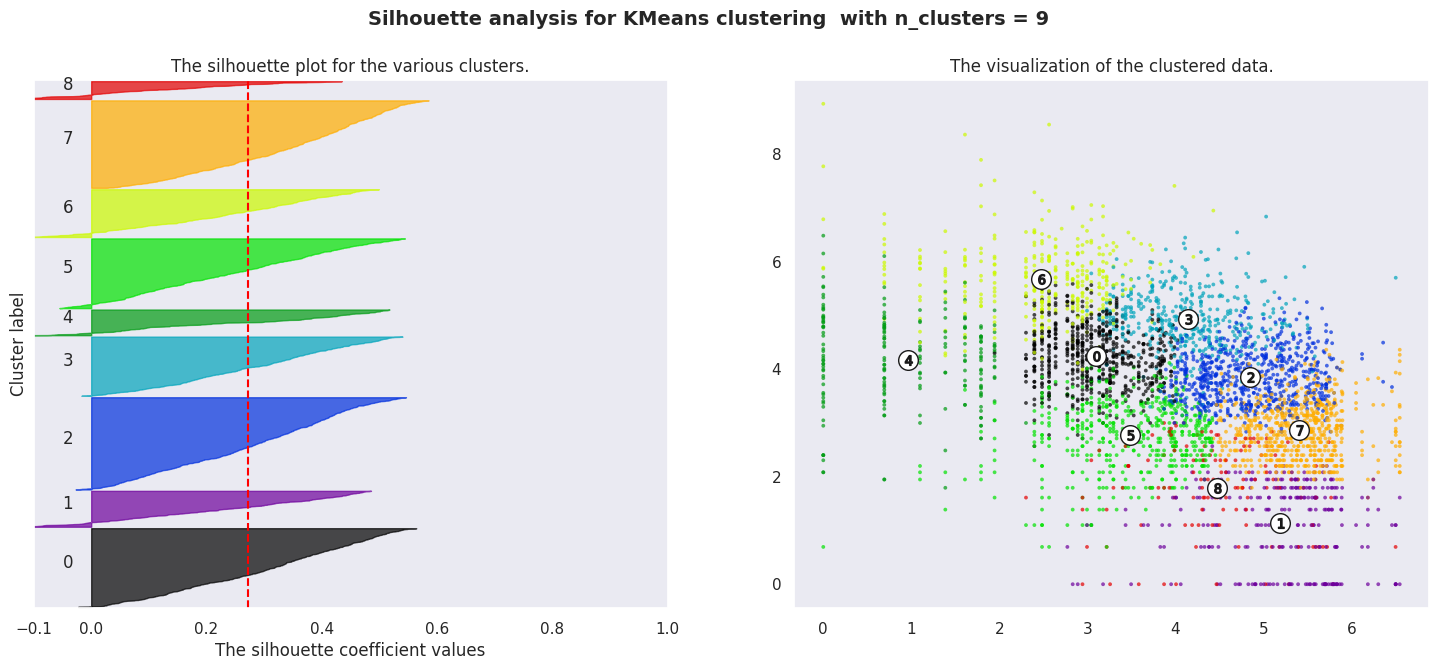

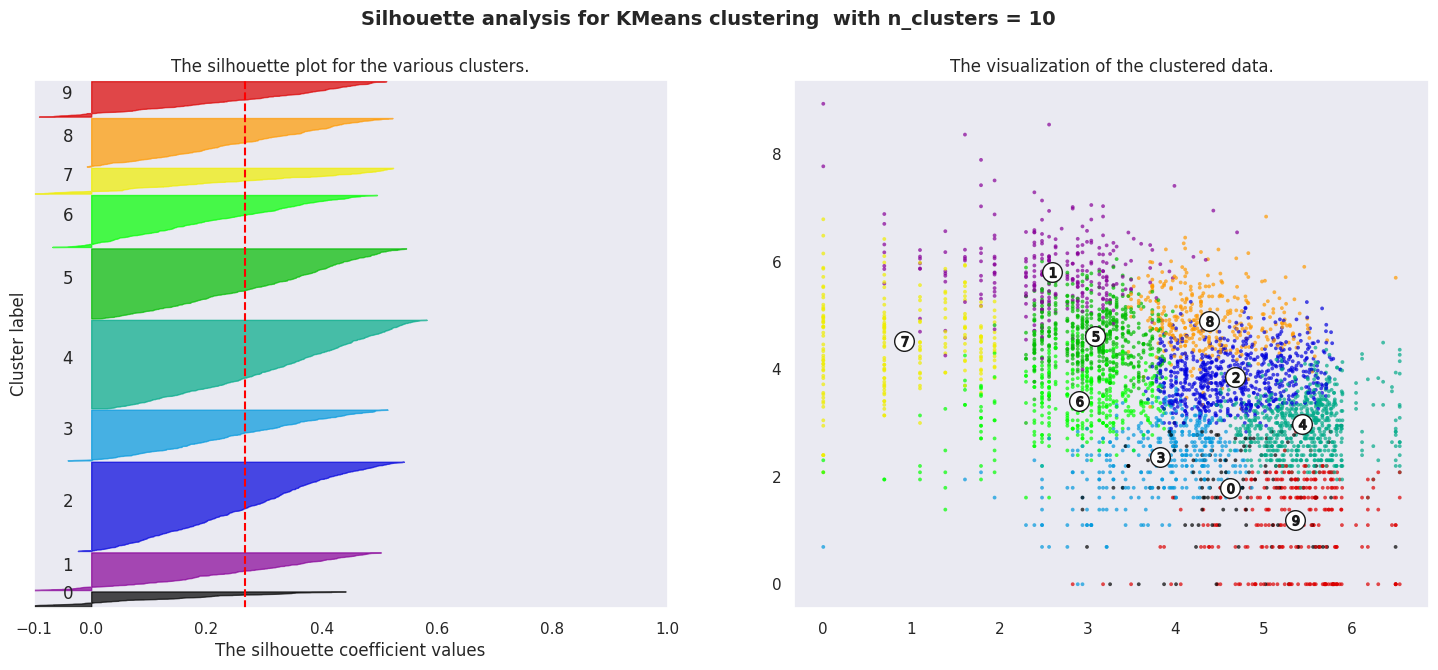

In [54]:
range_n_clusters = [2, 3, 4, 5, 6, 7, 8, 9, 10]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(ori_data_array) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(ori_data_array)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(ori_data_array, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(
        ori_data_array, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(ori_data_array[:, 0], ori_data_array[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")

    plt.suptitle(("Silhouette analysis for KMeans clustering  "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()



    We can also build snakeplots to understand and compare the segments. Let us build a snakeplot for our data with 4 clusters below.

    Before building snakeplots, let us assign back customer ID values to the row indices.


In [35]:
data_norm_k4.index = df['Customer ID'].astype(int)
data_norm_k4

,Recency,Frequency,MonetaryValue,Cluster
Customer ID,,,,
12346,5.789960,0.000000,11.253942,2
12747,3.178054,4.634729,8.341889,1
12748,1.609438,8.353026,10.387453,1
12749,3.178054,5.293305,8.316515,1
12820,3.828641,4.077537,6.848366,2
...,...,...,...,...
18280,5.081404,2.302585,5.196285,0
18281,1.609438,1.945910,4.392224,3
18282,5.379897,2.484907,5.182064,0


In [37]:
# Melt the data into along format so RFM values and metric names are stored in 1 column each
data_melted = pd.melt(data_norm_k4.reset_index(),
                      id_vars=['Customer ID', 'Cluster'],
                      value_vars=['Recency', 'Frequency', 'MonetaryValue'],
                      var_name='Attribute',
                      value_name='Value')

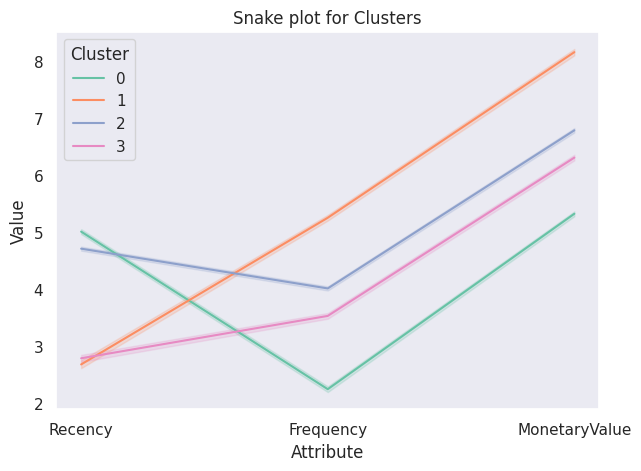

In [39]:
# Lets plot snake plot
sns.lineplot(x="Attribute", y="Value", hue='Cluster',
             data=data_melted, palette="Set2")
plt.title('Snake plot for Clusters')
plt.show()

    So this is distribution of recency, frequency, and monetary metric values across the four clusters. These four clusters look very wells separated from each other, which indicates a good heterogeneous mix of clusters.
    



    Lets find relative importance of each customer in segment: 
        1. Average of each cluster
        2. Average of population
        3. Importance score by dividing them and subtracting 1



### Assign Customer ID as index to data_k4

In [40]:
data_k4.index = df['Customer ID'].astype(int)
data_k4.head()

,Recency,Frequency,MonetaryValue,Cluster
Customer ID,,,,
12346,327,1,77183.60,2
12747,24,103,4196.01,1
12748,5,4243,32449.90,1
12749,24,199,4090.88,1
12820,46,59,942.34,2


In [42]:
data.index = df['Customer ID'].astype(int)
data.head()

,Recency,Frequency,MonetaryValue
Customer ID,,,
12346,327,1,77183.60
12747,24,103,4196.01
12748,5,4243,32449.90
12749,24,199,4090.88
12820,46,59,942.34


    Now lets find Cluster average and Population average

In [43]:
cluster_average = data_k4.groupby("Cluster").mean()
cluster_average

,Recency,Frequency,MonetaryValue
Cluster,,,
0,193.568562,13.027592,269.119867
1,22.082108,266.051471,6169.637500
2,134.570541,68.399290,1218.897962
3,21.248399,44.460948,682.994417


In [51]:
population_average = data.mean()
population_average

Recency           106.577296
Frequency          87.879847
MonetaryValue    1852.910256
dtype: float64

    Find relative importance

In [52]:
relative_importance = (cluster_average/population_average)-1
relative_importance

,Recency,Frequency,MonetaryValue
Cluster,,,
0,0.816227,-0.851757,-0.854758
1,-0.792807,2.027446,2.329701
2,0.262657,-0.221673,-0.342171
3,-0.800629,-0.494071,-0.631394


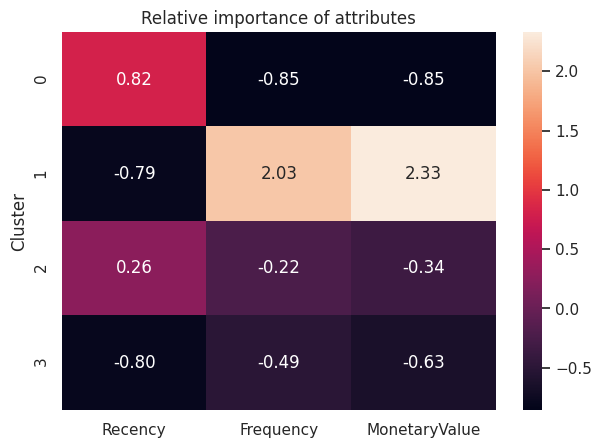

In [53]:
plt.title('Relative importance of attributes')
sns.heatmap(data=relative_importance, annot=True, fmt='.2f')
plt.show()

    So from above analysis,
        we can classify :
            Cluster 0:
                Customers who bought recently but had not bought more frequently those have   purchased small amount
            Cluster 1:
                Customers who have not purchased recently but buy more frequently with high monetary value
            Cluster 2:
                Customers who have bought recently but have low frequently purchased also they have low monetary value
            Cluster 3:
                Customers who made last transaction a long ago, also are not frequent buyers and also purchased very low amount.

## This was my understanding and got to learn so many new things from this and I am working on it to improve it more to get more better segments describing customers

    Future work:
        1. Improve segmentation 
        2. Also perform analysis using Demographic info, and other factors like geographical data,behaviourial patterns,psychographic data